## Visualize PLOS publication times scraped from their website

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import numpy
import IPython
import datetime
import time

%matplotlib inline

In [2]:
pubmed_df = pandas.read_table('data/pubmed-plos-dateparsed.tsv.gz', compression='gzip')
pubmed_df = pubmed_df[['doi', 'pubmed_id', 'journal', 'journal_abbrev']]

In [16]:
def date_to_float_year(date):
    """
    Convert a date into a decimal year.
    Source: http://stackoverflow.com/a/6451892/4651668
    """
    # returns seconds since epoch
    since_epoch = lambda date: time.mktime(date.timetuple())

    year_start = datetime.datetime(year=date.year, month=1, day=1)
    next_year_start = datetime.datetime(year=date.year+1, month=1, day=1)

    yearElapsed = since_epoch(date) - since_epoch(year_start)
    yearDuration = since_epoch(next_year_start) - since_epoch(year_start)
    return date.year + yearElapsed / yearDuration

In [17]:
date_df = pandas.read_table('data/scraped-plos.tsv', parse_dates=['received', 'accepted', 'published'])
date_df['acceptance_days'] = [td.days for td in date_df.accepted - date_df.received]
date_df['publication_days'] = [td.days for td in date_df.published - date_df.accepted]
date_df['total_days'] = [td.days for td in date_df.published - date_df.received]
date_df['published_year'] = date_df.published.map(date_to_float_year)
date_df = date_df.merge(pubmed_df)
len(date_df)

5776

In [18]:
date_df.head()

,doi,received,accepted,published,acceptance_days,publication_days,total_days,published_year,pubmed_id,journal,journal_abbrev
0,10.1371/journal.ppat.1004931,2014-11-14,2015-05-04,2015-06-09,171,36,207,2015.435502,26057557,PLoS pathogens,PLoS Pathog
1,10.1371/journal.pntd.0001279,2010-10-18,2011-07-05,2011-08-16,260,42,302,2011.621804,21858242,PLoS neglected tropical diseases,PLoS Negl Trop Dis
2,10.1371/journal.pbio.1001585,2013-02-26,2013-05-02,2013-06-11,65,40,105,2013.440982,23776409,PLoS biology,PLoS Biol
3,10.1371/journal.pmed.0050101,2007-08-14,2008-03-18,2008-05-27,217,70,287,2008.401526,18507497,PLoS medicine,PLoS Med
4,10.1371/journal.pcbi.1003558,2013-07-09,2014-02-19,2014-04-17,225,57,282,2014.290297,24743341,PLoS computational biology,PLoS Comput Biol


In [55]:
plot_df = date_df.copy()[['doi', 'journal_abbrev', 'published_year', 'publication_days']]
plot_df['Journal'] = plot_df['journal_abbrev']
family_df = plot_df.copy()
family_df['Journal'] = 'Family'
plot_df = pandas.concat([plot_df, family_df])

In [56]:
journal_palette = {
  'PLoS Comput Biol': '#16A127', 
  'PLoS Biol': '#16A127',
  'PLoS One': '#F8AF2D',
  'PLoS Med': '#891FB1',
  'PLoS Negl Trop Dis': '#891FB1',
  'PLoS Pathog': '#891FB1',
  'PLoS Genet': '#16A127'
}

In [57]:
seaborn.set_style('whitegrid')

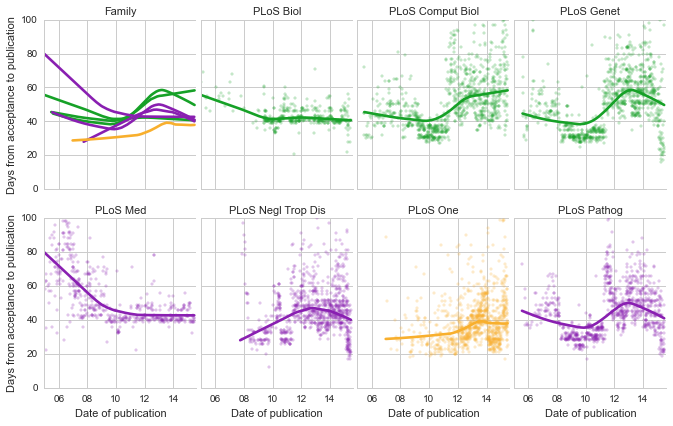

In [93]:
grid = seaborn.lmplot(
    x='published_year', y='publication_days', data=plot_df,
    col='Journal', hue='journal_abbrev', palette=journal_palette, legend=False,
    lowess=True, scatter=True, col_wrap=4,
    scatter_kws={'alpha': 0.25, 's': 10}, size = 3, aspect=0.8
);
plt.xlim((2005, 2015.6))
plt.ylim((0, 100))
grid.set_xlabels('Date of publication')
grid.set_ylabels('Days from acceptance to publication')
grid.set_titles('{col_name}')
grid.fig.subplots_adjust(wspace=.03, hspace=.17)
for ax in grid.axes:
    ax.set_xticklabels(['04', '06', '08', '10', '12', '14'])
del grid.axes[0].collections[:]
grid.savefig('figure/scraped-plos-publication-times.svg')
grid.savefig('figure/scraped-plos-publication-times.png', dpi=300)